<a href="https://colab.research.google.com/github/noamshimsho/NLP/blob/main/Chapter_9_Dealing_with_Few_to_No_Labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   Tagging - multilabel text classification ()
*   EDA
*   Naive Bayes classifier
*   zero-shot classification
*   Token perturbations
*   create a single-vector representation for each text. (pooling)
*   FAISS dataset - search engine for embeddings
*   enbedding K-nearest neighbor search.
*   Fine-Tuning Bert
*   Leveraging Unlabeled Data retraining Bert

The final models: 

* https://huggingface.co/GV05/bert-base-uncased-transformers-github-128

In [4]:
!pip install -q transformers[sentencepiece] datasets evaluate faiss-cpu # Faiss is a library for efficient similarity search and clustering of dense vectors.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.9 MB/s eta 0:00:00


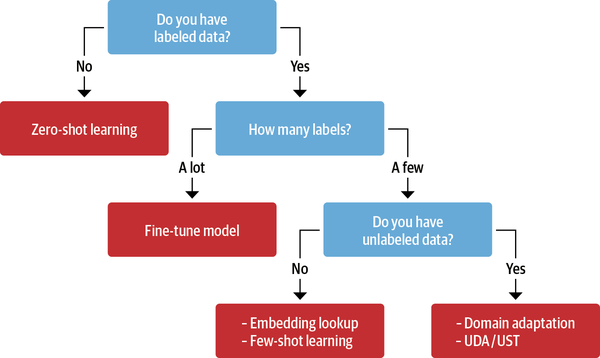

# Tagging issues as a Case Study (multilabel text classification problem)

In [5]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f"DataFrame shape: {df_issues.shape}")

DataFrame shape: (9930, 26)


In [6]:
df_issues.head(2)

,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,...,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,body,performed_via_github_app,pull_request
0,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849568459,MDU6SXNzdWU4NDk1Njg0NTk=,11046,Potential incorrect application of layer norm ...,...,NaN,0,2021-04-03 03:37:32,2021-04-03 03:37:32,NaT,NONE,None,"In BlenderbotSmallDecoder, layer norm is appl...",NaN,None
1,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://api.github.com/repos/huggingface/trans...,https://github.com/huggingface/transformers/is...,849544374,MDU6SXNzdWU4NDk1NDQzNzQ=,11045,Multi-GPU seq2seq example evaluation significa...,...,NaN,0,2021-04-03 00:52:24,2021-04-03 00:52:24,NaT,NONE,None,\r\n### Who can help\r\n@patil-suraj @sgugger ...,NaN,None


In [7]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


The labels column is the thing that we’re interested in, and each row contains a list of JSON objects with metadata about each label:

In [8]:
df_issues.loc[2, "labels"]

[{'id': 2659267025,
  'node_id': 'MDU6TGFiZWwyNjU5MjY3MDI1',
  'url': 'https://api.github.com/repos/huggingface/transformers/labels/DeepSpeed',
  'name': 'DeepSpeed',
  'color': '4D34F7',
  'default': False,
  'description': ''}]

For our purposes, we’re only interested in the name field of each label object, so let’s overwrite the labels column with just the label names:

In [9]:
df_issues["labels"] =  df_issues["labels"].apply(lambda x: [meta["name"] for meta in x])
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [10]:
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T


,0,1,2,3,4,5
labels,6440,3057,305,100,25,3


This shows that the majority of issues have zero or one label, and much fewer have more than one.

In [11]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts

wontfix                      2284
model card                    649
Core: Tokenization            106
New model                      98
Core: Modeling                 64
                             ... 
wandb                           1
fairscale                       1
Horizontal Model Parallel       1
fp16                            1
Replication                     1
Name: labels, Length: 65, dtype: int64

In [12]:
print(f"Number of labels: {len(df_counts)}")
# Display the top-8 label categories
df_counts.to_frame().head(8).T

Number of labels: 65


,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage
labels,2284,649,106,98,64,52,50,46


We can see that there are 65 unique labels in the dataset and that the classes are very imbalanced

In [13]:
label_map = {"Core: Tokenization": "tokenization",
             "New model": "new model",
             "Core: Modeling": "model training",
             "Usage": "usage",
             "Core: Pipeline": "pipeline",
             "TensorFlow": "tensorflow or tf",
             "PyTorch": "pytorch",
             "Examples": "examples",
             "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [14]:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [15]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
labels,106,98,64,46,42,41,37,28,24


In [16]:
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"

In [17]:
df_issues["split"].value_counts().to_frame()

,split
unlabeled,9489
labeled,441


In [18]:
# an example data

for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[26][:500]}\n")

title: Add new CANINE model

body: # 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually en

labels: ['new model']



In [19]:
df_issues["text"] = df_issues.apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1)

In [20]:
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before-len(df_issues))/len_before:.2%} duplicates.")

Removed 1.88% duplicates.


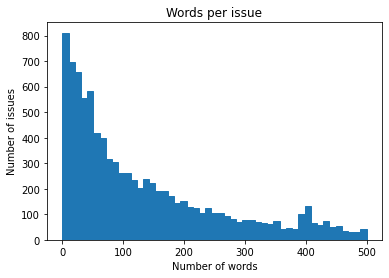

In [21]:
import numpy as np
import matplotlib.pyplot as plt

df_issues["text"].str.split().apply(len).hist(bins=np.linspace(0, 500, 50), grid=False, edgecolor="C0")
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

## Creating Training Sets

In [22]:
all_labels

['tokenization',
 'new model',
 'model training',
 'usage',
 'pipeline',
 'tensorflow or tf',
 'pytorch',
 'examples',
 'documentation']

In [23]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])


MultiLabelBinarizer()

In [24]:
mlb.transform([["tokenization", "new model"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0]])

In [25]:
mlb.transform([["pytorch"]])

array([[0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [26]:
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In this simple example we can see the first row has two ones corresponding to the tokenization and new model labels, 

while the second row has just one hit with pytorch.

In [27]:
!pip install scikit-multilearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 10.9 MB/s eta 0:00:00


Creating training and validation sets is a bit trickier for multlilabel problems because there is no guaranteed balance for all labels. 

However, it can be approximated, and we can use the **Scikit-multilearn** library, which is specifically set up for this purpose.

In [28]:
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels,test_size)
    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:,0]]

In [29]:
df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_clean.head(2)

,text,labels,split
0,Potential incorrect application of layer norm ...,[],unlabeled
1,Multi-GPU seq2seq example evaluation significa...,[],unlabeled


In [30]:
# unsupervised
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_unsup.head(2)

,text,labels
0,Potential incorrect application of layer norm ...,[]
1,Multi-GPU seq2seq example evaluation significa...,[]


In [31]:
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]
df_sup.head(2)

,text,labels
26,Add new CANINE model\n\n# 🌟 New model addition...,[new model]
107,Please implement DUMA: Reading Comprehension w...,[new model]


In [32]:
from sklearn.model_selection import train_test_split
np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [33]:
df_train.shape, df_valid.shape, df_test.shape

((223, 2), (106, 2), (111, 2))

In [34]:
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True))})

In [35]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

In [36]:
ds['unsup'][0]

{'text': 'Potential incorrect application of layer norm in BlenderbotSmallDecoder\n\nIn BlenderbotSmallDecoder,  layer norm is applied only on the token embeddings, and not on the hidden_states, whereas in the BlenderbotSmallEncoder, layer norm is applied after adding the input_embeds and positional embeds\r\n\r\nBlenderbotSmallEncoder:\r\n`hidden_states = inputs_embeds + embed_pos`\r\n`hidden_states = self.layernorm_embedding(hidden_states)`\r\n\r\nBlenderbotSmallDecoder:\r\n`inputs_embeds = self.layernorm_embedding(inputs_embeds)`\r\n`hidden_states = inputs_embeds + positions`',
 'labels': []}

## Creating Training Slices

The dataset has the two characteristics that we’d like to investigate in this chapter: 
*  sparse labeled data 
*  multilabel classification. 

The training set consists of only **220** examples to train with, which is certainly a challenge even with transfer learning. 

To drill down into how each method in this chapter performs with little labeled data, we’ll also create slices of the training data with even **fewer samples**. 

We can then plot the number of samples against the performance and investigate various regimes.

In [37]:
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
all_indices.shape, all_indices[0:3, 0]

((223, 1), array([0, 1, 2]))

In [38]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels))
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

Note that this iterative approach only approximately splits the samples to the desired size, since it is not always possible to find a balanced split at a given split size:

In [39]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


In [40]:
train_slices

[array([ 0,  2,  9, 11, 18, 19, 45, 52, 54, 92]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,  27,  30,  31,  33,  35,  36,  44,  57,  64,  69,
         73,  74,  78,  80,  90,  91,  99, 105, 123, 136, 141, 152, 180,
        184, 190, 197]),
 array([  0,   2,   9,  11,  18,  19,  45,  52,  54,  92,   1,   6,  10,
         12,  41,  56,  63,  88, 110,   3,   4,  14,  16,  22,  28,  40,
         55,  58,  60,  65,  89,  97, 118, 122, 132, 133,   5,  13,  15,
         20,  23,  25,

In [41]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels'],
        num_rows: 9303
    })
})

In [42]:
ds['train'][0]

{'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input e

# Implementing a Naive Bayesline

## Naive Bayes classifier

The Scikit-learn implementation of Naive Bayes does not support multilabel classification out of the box, 

but fortunately we can again use the Scikit-multilearn library to cast the problem as a one-versus-rest classification task where we train L binary classifiers for L labels.

In [43]:
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

ds = ds.map(prepare_labels, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [44]:
# measure the performance of our classifiers

from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [45]:
from sklearn.naive_bayes import MultinomialNB #The Multinomial Naive Bayes algorithm is a Bayesian learning approach popular in Natural Language Processing (NLP). The program guesses the tag of a text, such as an email or a newspaper story, using the Bayes theorem. It calculates each tag's likelihood for 
from sklearn.metrics import classification_report # Build a text report showing the main classification metrics.

from skmultilearn.problem_transform import BinaryRelevance # Performs classification per label. Transforms a multi-label classification problem with L labels into L single-label separate binary classification problems using the same base classifier provided in the constructor. The prediction output is the union of all per label classifiers
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts.


In [46]:
train_slice = train_slices[0]
train_slice

array([ 0,  2,  9, 11, 18, 19, 45, 52, 54, 92])

In [47]:
ds_train_sample = ds["train"].select(train_slice)
y_train = np.array(ds_train_sample["label_ids"])
y_test = np.array(ds["test"]["label_ids"])
y_train, y_test.shape, y_test[0:3]

(array([[0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 (111, 9),
 array([[0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0]]))

In [48]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
len(count_vect.get_feature_names_out())

887

In [50]:
count_vect.get_feature_names_out()[160:170]

array(['butcher', 'by', 'call', 'can', 'canine', 'caninemodel', 'cannot',
       'case', 'catalina', 'ccks2020'], dtype=object)

In [51]:
X_test_counts = count_vect.transform(ds["test"]["text"])
len(count_vect.get_feature_names_out())

887

In [52]:
classifier = BinaryRelevance(classifier=MultinomialNB())
classifier.fit(X_train_counts, y_train)
y_pred_test = classifier.predict(X_test_counts)
y_pred_test

<111x9 sparse matrix of type '<class 'numpy.int64'>'
	with 49 stored elements in Compressed Sparse Column format>

In [ ]:
clf_report = classification_report(y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,output_dict=True)
clf_report

In [54]:
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"]) # fit_transform
    X_test_counts = count_vect.transform(ds["test"]["text"]) # transform

    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

There’s quite a lot going on in this block of code, so let’s unpack it. 

First, we get the training slice and encode the labels. 

Then we use a count vectorizer to encode the texts by simply creating a vector of the size of the vocabulary where each entry corresponds to the frequency with which a token appeared in the text. 

This is called a bag-of-words approach, since all information on the order of the words is lost. 

Then we train the classifier and use the predictions on the test set to get the micro and macro F1-scores via the classification report.

micro F1 gives equal importance to each observation, whilst macro F1 gives each class equal importance.

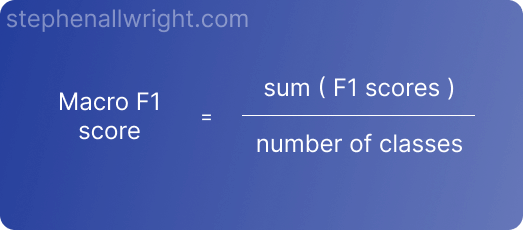

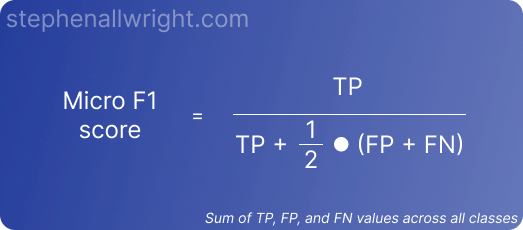

In [55]:
micro_scores

defaultdict(list,
            {'Naive Bayes': [0.3604651162790698,
              0.30208333333333337,
              0.41081081081081083,
              0.4435483870967742,
              0.5046728971962616,
              0.5346534653465347]})

In [56]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run,
                     linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run,
                     linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()

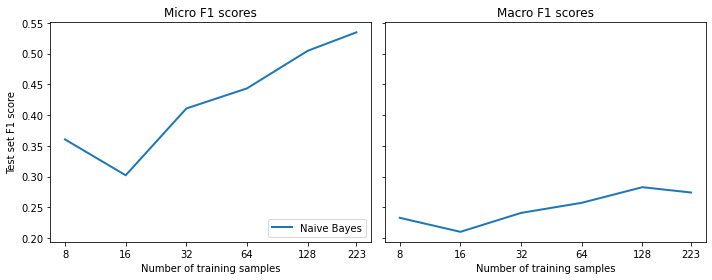

In [57]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

# Working with No Labeled Data (zero-shot classification)

The goal of zero-shot classification is to make use of a pretrained model without any additional fine-tuning on your task-specific corpus.

In [58]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [59]:
# zero shot example 
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


In [60]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


## using natural language inference (NLI) for zero-shot

The three classes in the MLNI dataset

His favourite color is blue. - He is into heavy metal music. -**neutral**

She finds the joke hilarious. - She thinks the joke is not funny at all - **contradiction**

The house was recently built. - The house is new. - **entailment**


Now, it turns out that we can hijack a model trained on the MNLI dataset to build a classifier without needing any labels at all! 

The key idea is to treat the text we wish to classify as the premise, and then formulate the hypothesis as:

“This example is about {label}.”

where we insert the class name for the label. 

The entailment score then tells us how likely that premise is to be about that topic.

Transformers has an MNLI model for zero-shot classification built in. We can initialize it via a pipeline as follows:

In [61]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0) # No model was supplied, defaulted to facebook/bart-large-mnli

No model was supplied, defaulted to facebook/bart-large-mnli and revision c626438 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [62]:
sample = ds["train"][0]
print(sample)
print(f"Labels: {sample['labels']}")
print(all_labels)

{'text': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input e

In [63]:
output = pipe(sample["text"], candidate_labels=all_labels, multi_label=True)

In [64]:
output

{'sequence': "Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained inp

In [65]:
print(output["sequence"][:400])
print("\nPredictions:")

for label, score in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


We can see that the model is very confident that this text is about a new model, but it also produces relatively high scores for the other labels.

In [66]:
def zero_shot_pipeline(example):
    output = pipe(example["text"], all_labels, multi_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

  0%|          | 0/106 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


Now that we have our scores, the next step is to determine which set of labels should be assigned to each example. 

There are a few options we can experiment with:

* Define a threshold and select all labels above the threshold.

* Pick the top k labels with the k highest scores.

To help us determine which method is best, let’s write a get_preds() function that applies one of the approaches to retrieve the predictions:

In [67]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [68]:
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True)

In [69]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False, fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report['micro avg']['f1-score'])
    macros.append(clf_report['macro avg']['f1-score'])

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

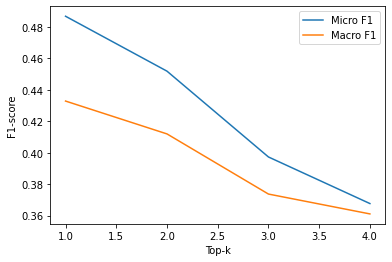

In [70]:
plt.plot(topks, micros, label='Micro F1')
plt.plot(topks, macros, label='Macro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc='best')
plt.show()

From the plot we can see that the best results are obtained by selecting the label with the highest score per example (top 1)

In [ ]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(ds_zero_shot)
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])

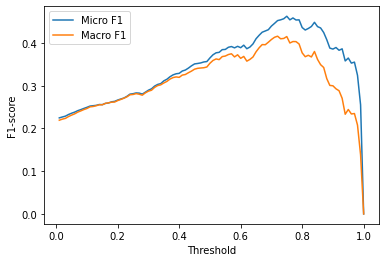

In [72]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [73]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')

Best threshold (micro): 0.75 with F1-score 0.46.
Best threshold (macro): 0.72 with F1-score 0.42.


Since the top-1 method performs best, let’s use this to compare zero-shot classification against Naive Bayes on the test set:

In [74]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report = get_clf_report(ds_zero_shot)
for train_slice in train_slices:
    macro_scores['Zero Shot'].append(clf_report['macro avg']['f1-score'])
    micro_scores['Zero Shot'].append(clf_report['micro avg']['f1-score'])

  0%|          | 0/111 [00:00<?, ?ex/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


  0%|          | 0/111 [00:00<?, ?ex/s]

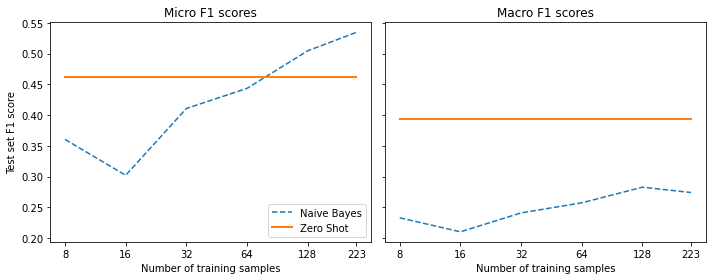

In [75]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot")

If you find it difficult to get good results on your own dataset, here are a few things you can do to improve the zero-shot pipeline:

The way the pipeline works makes it very sensitive to the names of the labels.

If the names don’t make much sense or are not easily connected to the texts, the pipeline will likely perform poorly. 

Either try using different names or use several names in parallel and aggregate them in an extra step.

Another thing you can improve is the form of the hypothesis. By default it is hypothesis="This is example is about {}", but you can pass any other text to the pipeline. Depending on the use case, this might improve the performance.


# Working with a Few Labels

## Data Augmentation

**Back translation**

Take a text in the source language, translate it into one or more target languages using machine translation, and then translate it back to the source language. Back translation tends to works best for high-resource languages or corpora that don’t contain too many domain-specific words.

**Token perturbations**

Given a text from the training set, randomly choose and perform simple transformations like random synonym replacement, word insertion, swap, or deletion.

You can implement back translation using machine translation models like M2M100. 

while libraries like **NlpAug** and **TextAttack** provide various recipes for token perturbations.

### Synonym replace

We’ll use the **ContextualWordEmbsAug** augmenter from **NlpAug** to leverage the contextual word embeddings of DistilBERT for our synonym replacements.

Let’s start with a simple example:

In [ ]:
!pip install nlpaug

In [77]:
import nlpaug.augmenter.word as naw
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cuda", action="substitute")

In [78]:
text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: ['these are the most popular transformers']


In [92]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += aug.augment(text)
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [93]:
r = augment_text(ds_train_sample[0:1])
len(r['text']) , len(r['label_ids'])

(2, 2)

In [94]:
r['label_ids']

[[0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0]]

In [95]:
r

{'text': ["Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input 

In [96]:
r['text'][0]

"Add new CANINE model\n\n# 🌟 New model addition\r\n\r\n## Model description\r\n\r\nGoogle recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:\r\n\r\n> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokenization step. While recent tokenization approaches based on data-derived subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally suited to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. In this paper, we present CANINE, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre-training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias. To use its finer-grained input effectivel

In [97]:
r['text'][1]

"add new canine implementation # [UNK] new model addition # # model description google recently proposed a new * * c * * haracter * * a * * rchitecture with * * n * * o tokenization * * i * * n * * n * * eural * * e * * ncoders architecture ( canine ). not only the software is exciting : > pipelined nlp systems have since been superseded by end - to - end neural modeling, yet nearly all commonly - deployed models still require an explicit tokenization step. while recent tokenization approaches based on data - oriented subword lexicons are less brittle than manually engineered tokenizers, these techniques are not equally applicable to all languages, and the use of any fixed vocabulary may limit a model's ability to adapt. in this paper, we present canine, a neural encoder that operates directly on character sequences, without explicit tokenization or vocabulary, and a pre - training strategy that operates either directly on characters or optionally uses subwords as a soft inductive bias

In [98]:
ds_train_sample = ds["train"].select(train_slices[0])
ds_train_sample

Dataset({
    features: ['text', 'labels', 'label_ids'],
    num_rows: 10
})

In [100]:
ds_train_sample.map(augment_text, batched=True, remove_columns=ds_train_sample.column_names).shuffle(seed=42)

  0%|          | 0/1 [00:00<?, ?ba/s]

Dataset({
    features: ['text', 'label_ids'],
    num_rows: 20
})

In [101]:
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    ds_train_sample = ds_train_sample.map(augment_text, batched=True, remove_columns=ds_train_sample.column_names).shuffle(seed=42)
    y_train = np.array(ds_train_sample["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])

    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"]) # fit_transform
    X_test_counts = count_vect.transform(ds["test"]["text"]) # transform

    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

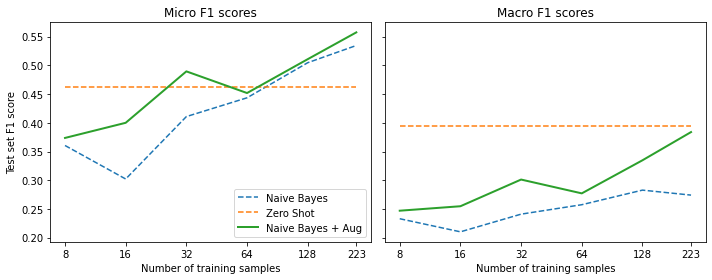

In [102]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

## Using Embeddings as a Lookup Table

The embeddings of large language models can be used to develop a semantic search engine, find similar documents or comments, or even classify text.

The idea follows a three-step process:



1.   Use the language model to embed all labeled texts.
2.   Perform a nearest neighbor search over the stored embeddings.
3.   Aggregate the labels of the nearest neighbors to get a prediction.



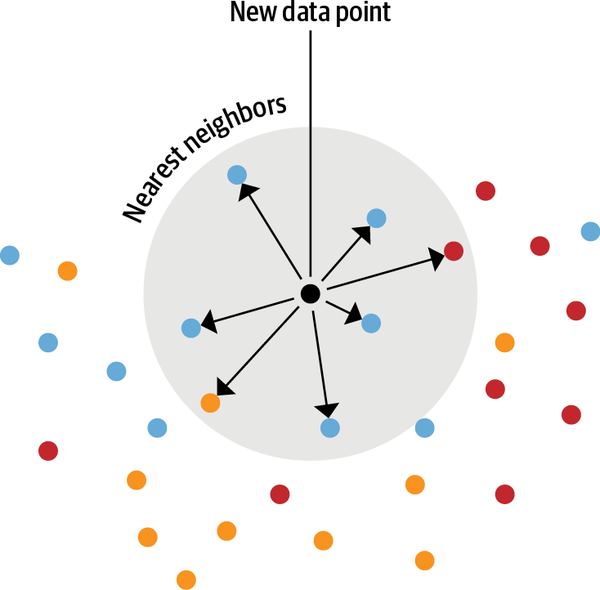

The beauty of this approach is that no model fine-tuning is necessary to leverage the few available labeled data points. 

Instead, the main decision to make this approach work is to select an appropriate model that is ideally pretrained on a similar domain to your dataset.

Since GPT-3 is only available through the OpenAI API, we’ll use GPT-2 to test the technique. 

Specifically, we’ll use a variant of GPT-2 that was trained on Python code, which will hopefully capture some of the context contained in our GitHub issues.

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)


Downloading:   0%|          | 0.00/792 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

Some weights of the model checkpoint at miguelvictor/python-gpt2-large were not used when initializing GPT2Model: ['lm_head.weight']
- This IS expected if you are initializing GPT2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model = model.to(device)

In [ ]:
"""
transformer models like GPT-2 will actually return one embedding vector per token.
But what we really want is a single embedding vector for the whole sentence.
To deal with this, we can use a technique called pooling.
we need to watch out for is that we don’t include padding tokens
"""
def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float())
    
    # Sum the embeddings, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # Return the average as a single vector
    return sum_embeddings / sum_mask



In [ ]:
def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True, max_length=128, return_tensors="pt")
    for k, v in inputs.items():
        inputs[k] = v.to(device)
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

In [ ]:
tokenizer.pad_token = tokenizer.eos_token # ValueError: Asking to pad but the tokenizer does not have a padding token. Please select a token to use as `pad_token` `(tokenizer.pad_token = tokenizer.eos_token e.g.)
examples = ds["train"][3:5]
examples = tokenizer(examples['text'], padding=True, truncation=True, max_length=128, return_tensors="pt")
print('attention mask:' , examples['attention_mask'].shape,  examples['attention_mask'])
print("input_ids shape" , examples['input_ids'].shape)

attention mask: torch.Size([2, 128]) tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])
input_ids shape torch.Size([2, 128])


In [ ]:
for k, v in examples.items():
  examples[k] = v.to(device)

In [ ]:
model_output = model(**examples)
token_embeddings = model_output.last_hidden_state
token_embeddings.shape, token_embeddings.size()

(torch.Size([2, 128, 1280]), torch.Size([2, 128, 1280]))

In [ ]:
attention_mask = examples['attention_mask']
attention_mask.shape, 

(torch.Size([2, 128]),)

In [ ]:
attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float().shape

torch.Size([2, 128, 1280])

In [ ]:
attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()[0,0,0:5]

tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [ ]:
input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()

In [ ]:
sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
sum_embeddings.shape

torch.Size([2, 1280])

In [ ]:
input_mask_expanded.sum(1)

tensor([[ 38.,  38.,  38.,  ...,  38.,  38.,  38.],
        [128., 128., 128.,  ..., 128., 128., 128.]], device='cuda:0')

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=4)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=4)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=4)

  0%|          | 0/56 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

In [ ]:
embs_test, len(embs_test[0]['embedding'])

(Dataset({
     features: ['text', 'labels', 'label_ids', 'embedding'],
     num_rows: 111
 }), 1280)

Now that we have all the embeddings, we need to set up a system to search them. 

We could write a function that calculates, say, the cosine similarity between a new text embedding that we’ll query and the existing embeddings in the training set. 

Alternatively, we can use a built-in structure of  Datasets called a **FAISS** index.

In [ ]:
embs_train.add_faiss_index(column = "embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

This created a new FAISS index called embedding. 

We can now perform a nearest neighbor lookup by calling the function **get_nearest_examples()**. 

It returns the closest neighbors as well as the matching score for each neighbor. 

We need to specify the query embedding as well as the number of nearest neighbors to retrieve. 

Let’s give it a spin and have a look at the documents that are closest to an example:

In [ ]:
k = 3 # Select the 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remove newlines in text for compact display

i = 0
query =  np.array(embs_valid[i]["embedding"], dtype=np.float32)

scores, samples = embs_train.get_nearest_examples("embedding", query, k=k)
print('query',query, query.shape)
print('scores',scores, scores.shape)


query [ 0.09181861  0.044488   -0.03502984 ...  0.2247527  -0.12956086
 -0.46726704] (1280,)
scores [54.92182  57.897568 60.124466] (3,)


In [ ]:
print(f"QUERY TRUE LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples["labels"], samples["text"]):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)} [...]")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY TRUE LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La [...]
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n [...]
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign [...]
SCORE: 60.12
LABELS: ['new model']


Nice! This is exactly what we hoped for: 

the three retrieved documents that we got via embedding lookup all have the same labels and we can already see from the titles that they are all very similar.

In [ ]:
# we’ll try several values for k and then vary the threshold m<k for label assignment with a helper function.

def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k + 1):
            _, samples = ds_train.get_nearest_examples_batch("embedding", valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred,
                target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report["micro avg"]["f1-score"]
            perf_macro[k, m] = clf_report["macro avg"]["f1-score"]
    return perf_micro, perf_macro

In [ ]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
print(valid_queries.shape, valid_labels.shape)
perf_micro, perf_macro = find_best_k_m(embs_train, valid_queries, valid_labels)

(106, 1280) (106, 9)


In [ ]:
# get_nearest_examples_batch
_, samples = embs_train.get_nearest_examples_batch("embedding", valid_queries, k=3)
s = samples[0]
type(samples), len(samples), type(s), len(s), s.keys(), s['label_ids']

(list,
 106,
 dict,
 4,
 dict_keys(['text', 'labels', 'label_ids', 'embedding']),
 [[0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0],
  [0, 0, 0, 1, 0, 0, 0, 0, 0]])

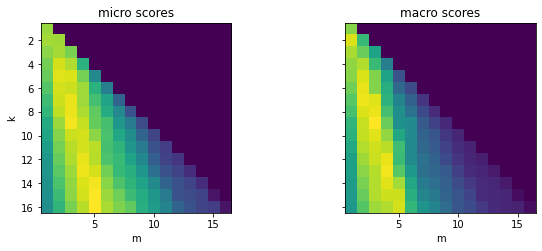

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

From the plots we can see that there is a pattern: choosing m too large or small for a given k yields suboptimal results. The best performance is achieved when choosing a ratio of approximately m/k=1/3. Let’s see which k and m give the best result overall:

In [ ]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


The perfomance is best when we choose k=15 and m=5, or in other words when we retrieve the 15 nearest neighbors and then assign the labels that occurred at least 5 times.

In [ ]:
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Create a Faiss index from training slice
    embs_train_tmp = embs_train.select(train_slice)
    embs_train_tmp.add_faiss_index("embedding")

    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(embs_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)

    # Get predictions on test set
    _, samples = embs_train_tmp.get_nearest_examples_batch("embedding",
                                                           test_queries,
                                                           k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred,
        target_names=mlb.classes_, zero_division=0, output_dict=True,)
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

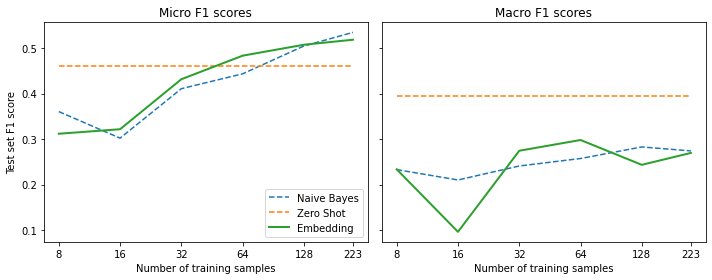

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

## Fine-Tuning a Vanilla Transformer



In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 9303
    })
})

In [ ]:
import torch
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)
    
ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(['labels', 'text'])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
# The multilabel loss function expects the labels to be of type float, since it also allows for class probabilities instead of discrete labels.
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)}, remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

  0%|          | 0/223 [00:00<?, ?ex/s]

  0%|          | 0/106 [00:00<?, ?ex/s]

  0%|          | 0/111 [00:00<?, ?ex/s]

  0%|          | 0/9303 [00:00<?, ?ex/s]

In [ ]:
ds_enc['train'][0]

{'input_ids': tensor([  101,  5587,  2047, 28735,  2944,  1001,   100,  2047,  2944,  2804,
          1001,  1001,  2944,  6412,  8224,  3728,  3818,  1037,  2047,  1008,
          1008,  1039,  1008,  1008, 18820, 21162,  1008,  1008,  1037,  1008,
          1008, 22110, 16584, 22471,  5397,  2007,  1008,  1008,  1050,  1008,
          1008,  1051, 19204,  3989,  1008,  1008,  1045,  1008,  1008,  1050,
          1008,  1008,  1050,  1008,  1008,  7327,  7941,  1008,  1008,  1041,
          1008,  1008, 13316, 27381,  2015,  4294,  1006, 28735,  1007,  1012,
          2025,  2069,  1996,  2516,  2003, 10990,  1024,  1028, 13117,  2094,
         17953,  2361,  3001,  2031,  4321,  2042, 19886,  2011,  2203,  1011,
          2000,  1011,  2203, 15756, 11643,  1010,  2664,  3053,  2035,  4141,
          1011,  2109,  4275,  2145,  5478,  2019, 13216, 19204,  3989,  3357,
          1012,  2096,  3522, 19204,  3989,  8107,  2241,  2006,  2951,  1011,
          5173,  4942, 18351, 16105,  8

Since we are likely to quickly overfit the training data due to its limited size, we set load_best_model_at_end=True and choose the best model based on the micro F1-⁠score:

In [ ]:
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", 
    num_train_epochs=20, 
    learning_rate=3e-5,
    lr_scheduler_type='constant', 
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32, 
    weight_decay=0.0,
    evaluation_strategy="epoch", 
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True, 
    metric_for_best_model='micro f1',
    save_total_limit=1, 
    log_level='error')

In [ ]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                     zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
            "macro f1": clf_dict["macro avg"]["f1-score"]}

Now we are ready to rumble! For each training set slice we train a classifier from scratch, load the best model at the end of the training loop, and store the results on the test set:

In [ ]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

In [ ]:
for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model, 
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],)

    trainer.train()
    
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.649800,0.612308,0.196796,0.101753
2,0.607500,0.582142,0.148837,0.051620
3,0.580500,0.548508,0.061538,0.031313
4,0.526500,0.517194,0.096552,0.039216
5,0.490900,0.482164,0.000000,0.000000
6,0.459000,0.449313,0.000000,0.000000
7,0.423700,0.430266,0.000000,0.000000
8,0.401200,0.416452,0.000000,0.000000
9,0.383600,0.401588,0.000000,0.000000
10,0.376800,0.391940,0.000000,0.000000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.609200,0.558726,0.053097,0.011905
2,0.516200,0.480430,0.000000,0.000000
3,0.455000,0.437803,0.000000,0.000000
4,0.410900,0.410883,0.000000,0.000000
5,0.380200,0.399574,0.000000,0.000000
6,0.352000,0.379772,0.000000,0.000000
7,0.336500,0.375178,0.000000,0.000000
8,0.318500,0.368880,0.000000,0.000000
9,0.303800,0.367359,0.000000,0.000000
10,0.282300,0.359208,0.000000,0.000000


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.581200,0.500043,0.000000,0.000000
2,0.450800,0.420980,0.000000,0.000000
3,0.392000,0.385464,0.000000,0.000000
4,0.349300,0.367550,0.000000,0.000000
5,0.323900,0.363203,0.000000,0.000000
6,0.299300,0.356396,0.016529,0.007937
7,0.281600,0.343722,0.000000,0.000000
8,0.260500,0.352806,0.171053,0.048964
9,0.248800,0.342307,0.016529,0.007937
10,0.224100,0.336393,0.212766,0.096642


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.536100,0.431373,0.000000,0.000000
2,0.395900,0.376077,0.000000,0.000000
3,0.355100,0.357177,0.000000,0.000000
4,0.336900,0.345148,0.000000,0.000000
5,0.314300,0.336396,0.000000,0.000000
6,0.282300,0.317612,0.275862,0.117284
7,0.263100,0.308506,0.244604,0.096626
8,0.232200,0.312883,0.335484,0.150763
9,0.211200,0.296271,0.465116,0.173659
10,0.189100,0.283972,0.417722,0.181826


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.458900,0.372504,0.000000,0.000000
2,0.348900,0.344994,0.000000,0.000000
3,0.315600,0.331696,0.233577,0.086721
4,0.293200,0.295354,0.331034,0.140741
5,0.256000,0.281816,0.488095,0.226473
6,0.221800,0.252803,0.529412,0.275510
7,0.189500,0.242153,0.514970,0.259215
8,0.159300,0.211595,0.590909,0.323140
9,0.126800,0.202407,0.645161,0.437662
10,0.108200,0.203249,0.663212,0.444847


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.426500,0.358504,0.000000,0.000000
2,0.331200,0.322583,0.152672,0.063492
3,0.287100,0.286324,0.392157,0.157071
4,0.243900,0.251381,0.502994,0.247748
5,0.202600,0.236015,0.493827,0.208382
6,0.171400,0.208297,0.609626,0.349133
7,0.139800,0.203167,0.679803,0.516620
8,0.114300,0.199542,0.670000,0.512980
9,0.087200,0.201531,0.702970,0.579744
10,0.067200,0.197696,0.711538,0.621772


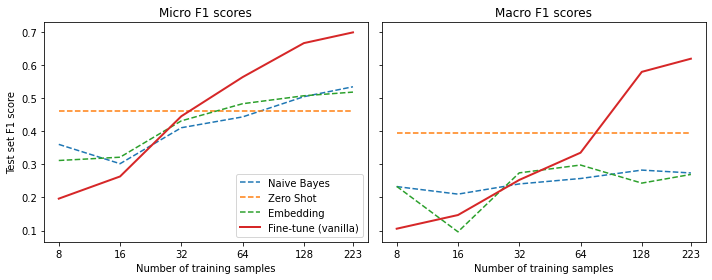

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

## In-Context and Few-Shot Learning with Prompts
We saw earlier in this chapter that we can use a language model like BERT or GPT-2 and adapt it to a supervised task by using prompts and parsing the model’s token predictions. This is different from the classic approach of adding a task-specific head and tuning the model parameters for the task. On the plus side, this approach does not require any training data, but on the negative side it seems we can’t leverage labeled data if we have access to it. There is a middle ground that we can sometimes take advantage of called in-context or few-shot learning.

To illustrate the concept, consider an English to French translation task. In the zero-shot paradigm, we would construct a prompt that might look as follows:

prompt = """\
Translate English to French:
thanks =>
"""
This hopefully prompts the model to predict the tokens of the word “merci”. We already saw when using GPT-2 for summarization in Chapter 6 that adding “TL;DR” to a text prompted the model to generate a summary without explicitly being trained to do this. 

An interesting finding of the GPT-3 paper was the ability of large language models to effectively learn from examples presented in the prompt—so, the previous translation example could be augmented with several English to French examples, which would make the model perform much better on this task.

Furthermore, the authors found that the larger the models are scaled, the better they are at using the in-context examples, leading to significant performance boosts. 

Although GPT-3-sized models are challenging to use in production, this is an exciting emerging research field and people have built cool applications, such as a natural language shell where commands are entered in natural language and parsed by GPT-3 to shell commands.

An alternative approach to using labeled data is to create examples of the prompts and desired predictions and continue training the language model on these examples. A novel method called ADAPET uses such an approach and beats GPT-3 on a wide variety of tasks, tuning the model with generated prompts. Recent work by Hugging Face researchers suggests that such an approach can be more data-efficient than fine-tuning a custom head.

In this section we briefly looked at various ways to make good use of the few labeled examples that we have. 
Very often we also have access to a lot of unlabeled data in addition to the labeled examples; in the next section we’ll discuss how to make good use of that.

# Leveraging Unlabeled Data

Naturally, if the downstream task has similar textual structure as the pretraining texts the transfer works better, so if we can bring the pretraining task closer to the downstream objective we could potentially improve the transfer.

Instead of retraining the language model from scratch, we can continue training it on data from our domain. 

In this step we use the classic language model objective of predicting masked words, which means we don’t need any labeled data.

## Fine-Tuning a Language Model

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 223
    })
    valid: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 106
    })
    test: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 111
    })
    unsup: Dataset({
        features: ['text', 'labels', 'label_ids'],
        num_rows: 9303
    })
})

In [ ]:
# tokenizing the data

def tokenize(batch):
    return tokenizer(batch["text"], 
                     truncation=True,
                     max_length=128, 
                     return_special_tokens_mask=True # mask the special tokens - [CLS] and [SEP])

ds_mlm = ds.map(tokenize, batched=True) # BERT
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
for k, v in ds_mlm["train"][0].items():
  print(k, v)

input_ids [101, 5587, 2047, 28735, 2944, 1001, 100, 2047, 2944, 2804, 1001, 1001, 2944, 6412, 8224, 3728, 3818, 1037, 2047, 1008, 1008, 1039, 1008, 1008, 18820, 21162, 1008, 1008, 1037, 1008, 1008, 22110, 16584, 22471, 5397, 2007, 1008, 1008, 1050, 1008, 1008, 1051, 19204, 3989, 1008, 1008, 1045, 1008, 1008, 1050, 1008, 1008, 1050, 1008, 1008, 7327, 7941, 1008, 1008, 1041, 1008, 1008, 13316, 27381, 2015, 4294, 1006, 28735, 1007, 1012, 2025, 2069, 1996, 2516, 2003, 10990, 1024, 1028, 13117, 2094, 17953, 2361, 3001, 2031, 4321, 2042, 19886, 2011, 2203, 1011, 2000, 1011, 2203, 15756, 11643, 1010, 2664, 3053, 2035, 4141, 1011, 2109, 4275, 2145, 5478, 2019, 13216, 19204, 3989, 3357, 1012, 2096, 3522, 19204, 3989, 8107, 2241, 2006, 2951, 1011, 5173, 4942, 18351, 16105, 8663, 2015, 2024, 102]
token_type_ids [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

What’s missing to start with masked language modeling is the mechanism to mask tokens in the input sequence and have the target tokens in the outputs.

A much more elegant solution is to use a **data collator**. 

Remember that the data collator is the function that builds the bridge between the dataset and the model calls. 

A batch is sampled from the dataset, and the data collator prepares the elements in the batch to feed them to the model. 

In the simplest case, it simply concatenates the tensors of each element into a single tensor. 

In our case we can use it to do the masking and label generation on the fly.

That way we don’t need to store the labels and we get new masks every time we sample. 
The data collator for this task is **called DataCollatorForLanguageModeling**. We initialize it with the model’s tokenizer and the fraction of tokens we want to mask via the mlm_probability argument. 

We’ll use this collator to mask 15% of the tokens, which follows the procedure in the BERT paper:

In [ ]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,  mlm_probability=0.15)

Let’s have a quick look at the data collator in action to see what it actually does.

In [ ]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
print(inputs)
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])
print(outputs)
data_collator.return_tensors = "pt"

{'input_ids': array([[  101, 19081,  2024, 12476,   999,   102]]), 'token_type_ids': array([[0, 0, 0, 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1]])}
{'input_ids': array([[  101, 19081,  2024, 12476,   103,   102]]), 'attention_mask': array([[1, 1, 1, 1, 1, 1]]), 'labels': array([[-100, -100, -100, -100,  999, -100]])}


In [ ]:
pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
    "Masked tokens": tokenizer.convert_ids_to_tokens(outputs["input_ids"][0]),
    "Original input_ids": inputs['input_ids'][0],
    "Masked input_ids": outputs["input_ids"][0],
    "Labels": outputs["labels"][0]}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Original input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
model_ckpt

'bert-base-uncased'

In [ ]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
                    output_dir = f"{model_ckpt}-transformers-github-128", 
                    per_device_train_batch_size=16,
                    logging_strategy="epoch", 
                    evaluation_strategy="epoch", 
                    save_strategy="no",
                    num_train_epochs=16, 
                    push_to_hub=True, 
                    log_level="error", 
                    report_to="none")

trainer = Trainer(
              model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
              tokenizer=tokenizer, 
              args=training_args, 
              data_collator=data_collator,
              train_dataset=ds_mlm["unsup"], 
              eval_dataset=ds_mlm["train"])

trainer.train()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.8/dist-packages/huggingface_hub/repository.py:725: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.12. Please create the repository first using `create_repo(..., exists_ok=True)`.
  warnings.warn(
Cloning https://huggingface.co/GV05/bert-base-uncased-transformers-github-128 into local empty di

{'loss': 2.0247, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.6457043886184692, 'eval_runtime': 2.2156, 'eval_samples_per_second': 100.65, 'eval_steps_per_second': 12.638, 'epoch': 1.0}
{'loss': 1.5989, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.4156569242477417, 'eval_runtime': 2.2233, 'eval_samples_per_second': 100.303, 'eval_steps_per_second': 12.594, 'epoch': 2.0}
{'loss': 1.4449, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.3493857383728027, 'eval_runtime': 2.2219, 'eval_samples_per_second': 100.363, 'eval_steps_per_second': 12.602, 'epoch': 3.0}
{'loss': 1.3579, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.377423882484436, 'eval_runtime': 2.217, 'eval_samples_per_second': 100.588, 'eval_steps_per_second': 12.63, 'epoch': 4.0}
{'loss': 1.3039, 'learning_rate': 3.4375e-05, 'epoch': 5.0}
{'eval_loss': 1.1908316612243652, 'eval_runtime': 2.2297, 'eval_samples_per_second': 100.013, 'eval_steps_per_second'

TrainOutput(global_step=9312, training_loss=1.229072328285663, metrics={'train_runtime': 4304.3578, 'train_samples_per_second': 34.581, 'train_steps_per_second': 2.163, 'train_loss': 1.229072328285663, 'epoch': 16.0})

In [ ]:
trainer.push_to_hub("Training complete!")

Upload file pytorch_model.bin:   0%|          | 3.30k/418M [00:00<?, ?B/s]

Upload file training_args.bin:  98%|#########7| 3.30k/3.37k [00:00<?, ?B/s]

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/GV05/bert-base-uncased-transformers-github-128
   aacc058..7497123  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/GV05/bert-base-uncased-transformers-github-128
   aacc058..7497123  main -> main

To https://huggingface.co/GV05/bert-base-uncased-transformers-github-128
   7497123..4ffa8ee  main -> main

   7497123..4ffa8ee  main -> main



'https://huggingface.co/GV05/bert-base-uncased-transformers-github-128/commit/74971236c206aef5234fd404c2a407e0f0a1149b'

We can access the trainer’s log history to look at the training and validation losses of the model. 

All logs are stored in **trainer.state.log_history** as a list of dictionaries that we can easily load into a Pandas DataFrame. 

Since the training and validation loss are recorded at different steps, there are missing values in the dataframe. For this reason we drop the missing values before plotting the metrics:

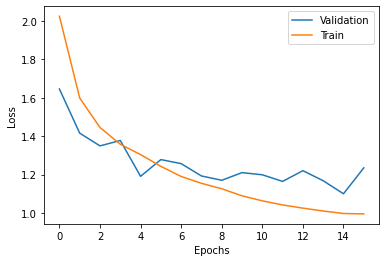

In [ ]:
df_log = pd.DataFrame(trainer.state.log_history)

df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"].plot(label="Validation")
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

## Fine-Tuning a Classifier

In [ ]:
model_ckpt = f"GV05/{model_ckpt}-transformers-github-128"  
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                               config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc['test'])
    metrics = compute_metrics(pred)
    # DA refers to domain adaptation
    macro_scores['Fine-tune (DA)'].append(metrics['macro f1'])
    micro_scores['Fine-tune (DA)'].append(metrics['micro f1'])

Downloading:   0%|          | 0.00/664 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at GV05/bert-base-uncased-transformers-github-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.640800,0.563554,0.000000,0.000000
2,0.532300,0.486261,0.000000,0.000000
3,0.481000,0.436481,0.000000,0.000000
4,0.417600,0.407362,0.000000,0.000000
5,0.376800,0.388355,0.000000,0.000000
6,0.356800,0.377045,0.000000,0.000000
7,0.333100,0.370011,0.000000,0.000000
8,0.305800,0.364729,0.000000,0.000000
9,0.295400,0.360510,0.000000,0.000000
10,0.288400,0.356234,0.000000,0.000000


Some weights of the model checkpoint at GV05/bert-base-uncased-transformers-github-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.614000,0.514837,0.000000,0.000000
2,0.488500,0.425556,0.000000,0.000000
3,0.394400,0.389563,0.000000,0.000000
4,0.351100,0.370250,0.000000,0.000000
5,0.336500,0.360478,0.000000,0.000000
6,0.311900,0.354298,0.000000,0.000000
7,0.291100,0.347847,0.000000,0.000000
8,0.260600,0.340482,0.000000,0.000000
9,0.241500,0.337435,0.000000,0.000000
10,0.216300,0.332090,0.032787,0.017094


Some weights of the model checkpoint at GV05/bert-base-uncased-transformers-github-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.561000,0.439114,0.000000,0.000000
2,0.396400,0.377556,0.000000,0.000000
3,0.346300,0.359575,0.000000,0.000000
4,0.315000,0.347727,0.000000,0.000000
5,0.288400,0.333008,0.000000,0.000000
6,0.255900,0.317354,0.167939,0.075932
7,0.224200,0.310681,0.233577,0.104575
8,0.196400,0.304008,0.244604,0.109244
9,0.175400,0.304654,0.244604,0.123126
10,0.157300,0.298684,0.305556,0.147019


Some weights of the model checkpoint at GV05/bert-base-uncased-transformers-github-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.499500,0.383049,0.000000,0.000000
2,0.365100,0.355346,0.000000,0.000000
3,0.330300,0.334663,0.000000,0.000000
4,0.292400,0.310038,0.319444,0.136400
5,0.248800,0.290009,0.374194,0.149170
6,0.200400,0.274522,0.422360,0.204693
7,0.172700,0.259880,0.453988,0.237537
8,0.145800,0.255704,0.502994,0.312034
9,0.122300,0.245352,0.485207,0.310500
10,0.108500,0.238385,0.508671,0.328570


Some weights of the model checkpoint at GV05/bert-base-uncased-transformers-github-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.431400,0.356560,0.000000,0.000000
2,0.332400,0.309444,0.309859,0.131222
3,0.281800,0.278146,0.433121,0.169444
4,0.227600,0.243996,0.466258,0.242345
5,0.182000,0.226205,0.579545,0.368548
6,0.144000,0.207994,0.622951,0.441584
7,0.109600,0.202836,0.638298,0.460041
8,0.086400,0.199150,0.676923,0.548035
9,0.069700,0.192786,0.676768,0.570972
10,0.060900,0.193677,0.677083,0.533444


Some weights of the model checkpoint at GV05/bert-base-uncased-transformers-github-128 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint a

Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.400100,0.336966,0.000000,0.000000
2,0.298700,0.270045,0.509091,0.270385
3,0.238900,0.218207,0.584270,0.317062
4,0.182000,0.196675,0.634409,0.402115
5,0.132100,0.200617,0.627660,0.448203
6,0.098300,0.172974,0.693878,0.579006
7,0.072800,0.169466,0.723618,0.635761
8,0.056100,0.164895,0.702439,0.630740
9,0.049100,0.169557,0.714286,0.624343
10,0.038500,0.164345,0.717172,0.640710


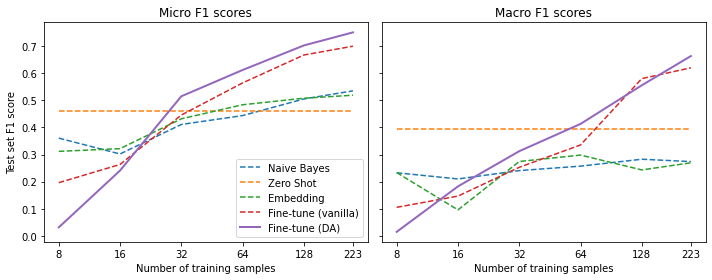

In [ ]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")

In [ ]:
print(micro_scores)

defaultdict(<class 'list'>, {'Naive Bayes': [0.3604651162790698, 0.30208333333333337, 0.41081081081081083, 0.4435483870967742, 0.5046728971962616, 0.5346534653465347], 'Zero Shot': [0.4615384615384615, 0.4615384615384615, 0.4615384615384615, 0.4615384615384615, 0.4615384615384615, 0.4615384615384615], 'Embedding': [0.31176470588235294, 0.32167832167832167, 0.4316109422492402, 0.4834123222748815, 0.5074626865671641, 0.5185185185185186], 'Fine-tune (vanilla)': [0.19642857142857142, 0.2634730538922156, 0.4455958549222798, 0.5638297872340425, 0.6666666666666666, 0.6991150442477877], 'Fine-tune (DA)': [0.03174603174603175, 0.24113475177304966, 0.5146198830409356, 0.6113989637305699, 0.7019230769230769, 0.7500000000000001]})


In [ ]:
print(macro_scores)

defaultdict(<class 'list'>, {'Naive Bayes': [0.23288166214995487, 0.21006897585844955, 0.24086240556828795, 0.25730500818220114, 0.28271105113210376, 0.27403710305671086], 'Zero Shot': [0.39372541039207704, 0.39372541039207704, 0.39372541039207704, 0.39372541039207704, 0.39372541039207704, 0.39372541039207704], 'Embedding': [0.2335927572655292, 0.09608708443659901, 0.27436131670002634, 0.2980009468399694, 0.24339086839086838, 0.2695956794628521], 'Fine-tune (vanilla)': [0.10551528406223765, 0.14685931352598022, 0.2529478867507036, 0.33532402619015145, 0.5797775952497863, 0.6194978808996106], 'Fine-tune (DA)': [0.01532567049808429, 0.18270682063785512, 0.31230786549935485, 0.4127713403075722, 0.5551357333056679, 0.6628029169382552]})


# SetFit: Efficient Few-Shot Learning Without Prompts

https://huggingface.co/blog/setfit -BLOG

https://github.com/huggingface/setfit - GITHUB

https://www.youtube.com/watch?v=8h27lV8v8BU&t=2700s&ab_channel=HuggingFace - YOUTUBE

practice

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
y_pred

Number of mislabeled points out of a total 75 points : 4


array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 2, 0,
       0, 1, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 0, 2, 1, 1, 1,
       1, 2, 0, 0, 2, 1, 0, 0, 1])

In [ ]:
from sklearn.naive_bayes import MultinomialNB
"""
MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, 
and is one of the two classic naive Bayes variants used in text classification 
(where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice).

"""
gnb = MultinomialNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
y_pred

Number of mislabeled points out of a total 75 points : 30


array([2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2,
       0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 0, 2, 2, 0, 0, 2])

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
 'This is the first document.',
'This document is the second document.',
'And this is the third one.',
'Is this the first document?',
]
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(X.toarray())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]


In [ ]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.50      1.00      0.67         1
     class 1       0.00      0.00      0.00         1
     class 2       1.00      0.67      0.80         3

    accuracy                           0.60         5
   macro avg       0.50      0.56      0.49         5
weighted avg       0.70      0.60      0.61         5

